# Metrics learning. Практика.

В данном задании нам предстоит кластеризовать клиентов банка по характеру финансового поведения с продуктом банка (кредитная карта). 

## Загрузим необходимые данные и библиотеки

In [330]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings(action="ignore")

In [331]:
data= pd.read_csv("data/CC GENERAL.csv")
print(data.shape)
data.head()

(8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


* CUSTID: Идентификационный номер держателя карты
* BALANCE: Доступный для трат баланс
* BALANCEFREQUENCY: Признак, показывающий как часто обновляется баланс, изменяется от 0 (никогда не обновляется) до 1 (очень часто обновляется)
* PURCHASES: Количество покупок сделанное с карты
* ONEOFFPURCHASES: Максимально поличество покупок «за раз»
* INSTALLMENTSPURCHASES: Сумма покупок в рассрочку
* CASHADVANCE: Сумма овердрафта
* PURCHASESFREQUENCY: Признак, показывающий как часто делаются покупки с карты, изменяется от 0 (никогда не используется) до 1 (постоянно используется)
* ONEOFFPURCHASESFREQUENCY: Признак, показывающий как часто Покупки происходят за один раз, изменяется от 0 (редко покупаются) до 1 (часто покупаются)
* PURCHASESINSTALLMENTSFREQUENCY: Признак, показывающий как часто Покупки происходят в рассрочку, изменяется от 0 (редко покупаются) до 1 (часто покупаются)
* CASHADVANCEFREQUENCY: Как часто платится овердрафтом
* CASHADVANCETRX: Количество оплат в овердрафте
* PURCHASESTRX: Количество транзакций покупок
* CREDITLIMIT: Лимит кредита по карте
* PAYMENTS: Задолженность по карте
* MINIMUM_PAYMENTS: Минимальный платеж по задолженности
* PRCFULLPAYMENT: Платеж для беспроцентного периода
* TENURE: Стоимость обслуживания карты

## Обработка данных

Посмотрим на статистики, вызвав метод describe.

In [332]:
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Видим много выбросов, постараемся избавится от них, сделав диапазоны значений для различных колонок.

## Работа с пропусками

### Задание 8.1
Выведите количество пропусков. количество пропусков в признаке `MINIMUM_PAYMENTS` используйте как ответ на задание 8.1

In [333]:
#Ваш код здесь
data.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Заполните значения `MINIMUM_PAYMENTS`, `CREDIT_LIMIT` средним значением:

In [334]:
data.loc[(data['MINIMUM_PAYMENTS'].isnull()==True),'MINIMUM_PAYMENTS']=data['MINIMUM_PAYMENTS'].mean() # ваш код здесь  
data.loc[(data['CREDIT_LIMIT'].isnull()==True),'CREDIT_LIMIT']= data['CREDIT_LIMIT'].mean() #ваш код 

Проверим еще раз, что пропусков более нет

In [335]:
# ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA


## Работа с выбросами

Для работы с выбросами сделаем диапазоновые значения признаков, для этого будем использовать функцию

In [336]:
def add_range(df, columns, range_list, onesided = True):
    for column in columns:
        name = column + '_range'
        df[name] = 0
        for i in range(len(range_list)-1):
            df.loc[(df[column] > range_list[i])&(df[column] <= range_list[i+1]), name] = i+1
            if onesided:
                df.loc[(df[column] >range_list[-1]), name] = len(range_list)
    df.drop(columns, axis = 1, inplace = True)

In [337]:
add_range(data,['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
        'PAYMENTS', 'MINIMUM_PAYMENTS'], [0,500,1000,3000,5000,10000])

In [338]:
add_range(data,['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 
         'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT'] , np.linspace(0,1,11),onesided=False)

In [339]:
add_range(data,['PURCHASES_TRX', 'CASH_ADVANCE_TRX'] ,[0,5,10,15,20,30,50,100] ,onesided=False)

In [340]:
data

,CUST_ID,TENURE,BALANCE_range,PURCHASES_range,ONEOFF_PURCHASES_range,INSTALLMENTS_PURCHASES_range,CASH_ADVANCE_range,CREDIT_LIMIT_range,PAYMENTS_range,MINIMUM_PAYMENTS_range,BALANCE_FREQUENCY_range,PURCHASES_FREQUENCY_range,ONEOFF_PURCHASES_FREQUENCY_range,PURCHASES_INSTALLMENTS_FREQUENCY_range,CASH_ADVANCE_FREQUENCY_range,PRC_FULL_PAYMENT_range,PURCHASES_TRX_range,CASH_ADVANCE_TRX_range
0,C10001,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0
1,C10002,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1
2,C10003,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0
3,C10004,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1
4,C10005,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,6,1,1,0,1,0,2,1,1,10,10,0,9,0,5,2,0
8946,C19187,6,1,1,0,1,0,2,1,2,10,10,0,9,0,0,2,0
8947,C19188,6,1,1,0,1,0,2,1,1,9,9,0,7,0,3,1,0
8948,C19189,6,1,0,0,0,1,1,1,1,9,0,0,0,2,3,0,1


In [341]:
data.drop(['CUST_ID'], axis=1, inplace=True)

X= np.asarray(data)

### Стандартизация данных

In [342]:
scale = StandardScaler()
X = scale.fit_transform(X)
X.shape

(8950, 17)

Определимся с количеством кластеров

### Задание 8.2
Используя `KElbowVisualizer` из модуля `yellowbrick.cluster` определите оптимальное количество кластеров. Для этого на вход `KElbowVisualizer` подайте модель `Kmeans`, максимальное количество кластеров следует ограничить до `k=20`. Ответом на задание является количество кластеров. 

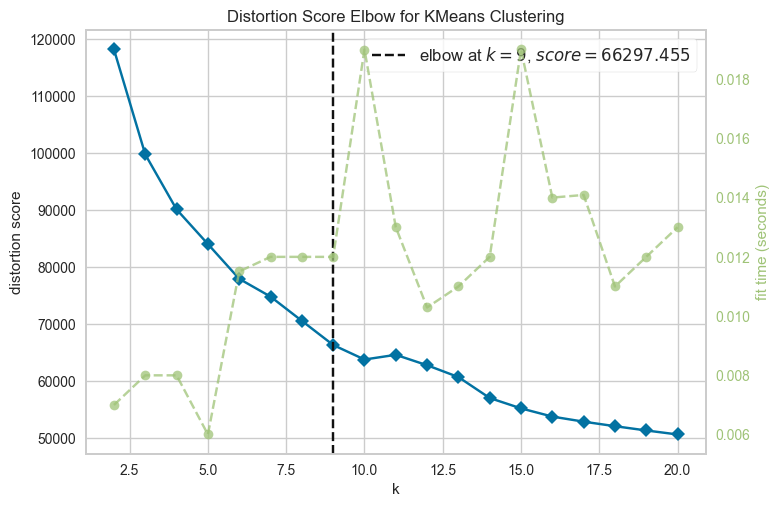

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [343]:
from yellowbrick.cluster import KElbowVisualizer

#ваш код

Elbow_M = KElbowVisualizer(KMeans(random_state=42), k=20)
Elbow_M.fit(X)
Elbow_M.show()

Для корректной работы в дальнейшем предлагается внести ответ в качестве переменной

In [344]:
k_clust = 8 # сюда вставить ответ на задачу 8.2

## Кластеризация

Обучите модель `Kmeans`с количеством кластеров, полученном в задании 6.2, с помощью метода

In [345]:
kmean= KMeans(k_clust)
kmean.fit(X) 
labels=kmean.labels_

In [346]:
clusters=pd.concat([data, pd.DataFrame({'cluster':labels})], axis=1)
clusters.head()

,TENURE,BALANCE_range,PURCHASES_range,ONEOFF_PURCHASES_range,INSTALLMENTS_PURCHASES_range,CASH_ADVANCE_range,CREDIT_LIMIT_range,PAYMENTS_range,MINIMUM_PAYMENTS_range,BALANCE_FREQUENCY_range,PURCHASES_FREQUENCY_range,ONEOFF_PURCHASES_FREQUENCY_range,PURCHASES_INSTALLMENTS_FREQUENCY_range,CASH_ADVANCE_FREQUENCY_range,PRC_FULL_PAYMENT_range,PURCHASES_TRX_range,CASH_ADVANCE_TRX_range,cluster
0,12,1,1,0,1,0,2,1,1,9,2,0,1,0,0,1,0,1
1,12,4,0,0,0,5,5,4,3,10,0,0,0,3,3,0,1,6
2,12,3,2,2,0,0,5,2,2,10,10,10,0,0,0,3,0,7
3,12,3,3,3,0,1,5,0,2,7,1,1,0,1,0,1,1,7
4,12,2,1,1,0,0,3,2,1,10,1,1,0,0,0,1,0,1


## Анализ результатов кластеризации

In [347]:
# # раскомментируйте код для получения информации о распределениях признаков для каждого кластера
# for c in clusters:
#     grid= sns.FacetGrid(clusters, col='cluster')
#     grid.map(plt.hist, c)

#### Место для ваших выводов

Визуализируем кластеры, предварительно уменьшив разменость с помощью PCA до 2-х


In [348]:
pca = PCA(2)
pca.fit(X)
X_PCA = pca.transform(X)
X_PCA.shape

(8950, 2)

### Задача 8.3 
C помощью атрибута `explained_variance_ratio_` выведите процент объясненной дисперсии по обоим из осей. В качестве ответа внесите максимальное значение, округленное до десятых.

In [349]:
# ваш код здесь
np.round(pca.explained_variance_ratio_, 1)

array([0.3, 0.2])

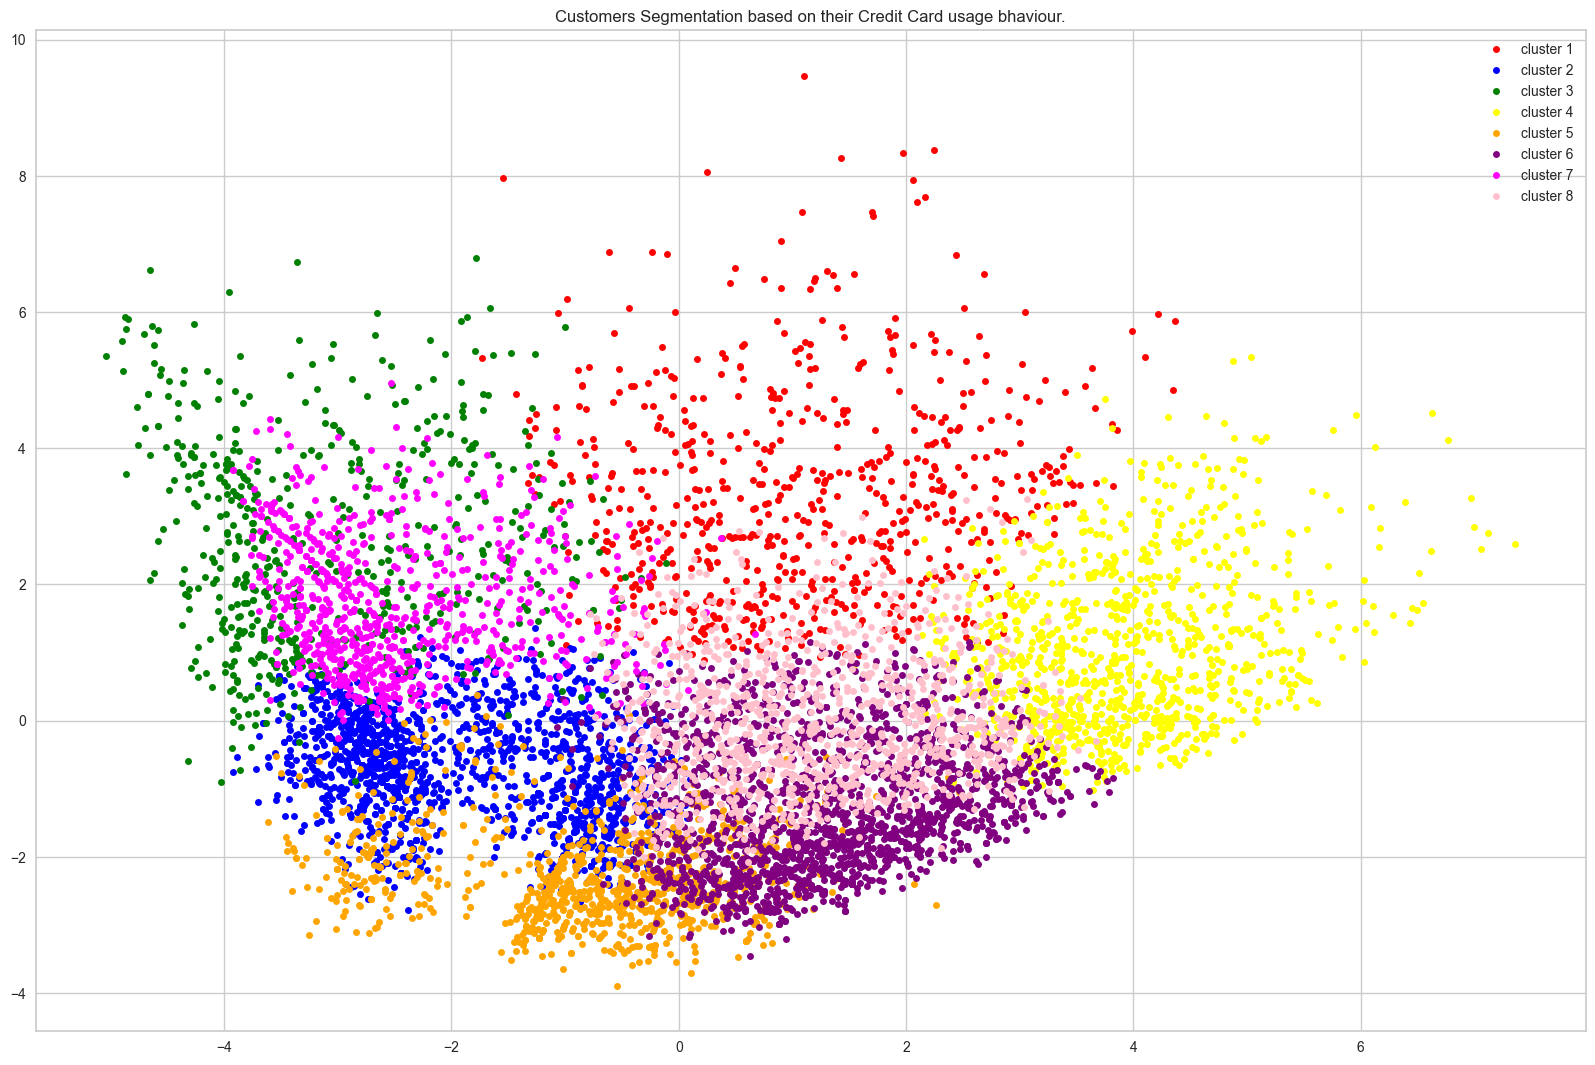

In [350]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5: 'purple',
          6: 'fuchsia',
          7: 'pink'}

names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name], label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()

Как мы видим, результат достаточно неочевидный, для более красивой визуализации вычислим косинусное расстояние от исходных данных и применим к ним PCA.

Напомним, что косинусное расстояние имеет вид: $$1 - \frac{u  v}{||u||||v||}$$
В модуле `sklearn.metrics.pairwise` реализовано вычитаемое в данной разнице в функции `cosine_similarity` предлагается реализовать функцию `cos_dist` косинусного расстояния на основе данной встроенной функции.

In [351]:
def cos_dist(X):
     return 1 - cosine_similarity(X) # здесь реализация

In [352]:
dist = cos_dist(X)

pca = PCA(2)
pca.fit(dist)
X_PCA = pca.transform(dist)
X_PCA.shape

(8950, 2)

### Задача 8.4 
С помощью атрибута `explained_variance_ratio_` выведите процент объясненной дисперсии по обоим из осей после применения **косинусного значения**. В качестве ответа внесите максимальное значение, округленное до десятых.

In [353]:
#ваш код
np.round(pca.explained_variance_ratio_, 1)

array([0.6, 0.3])

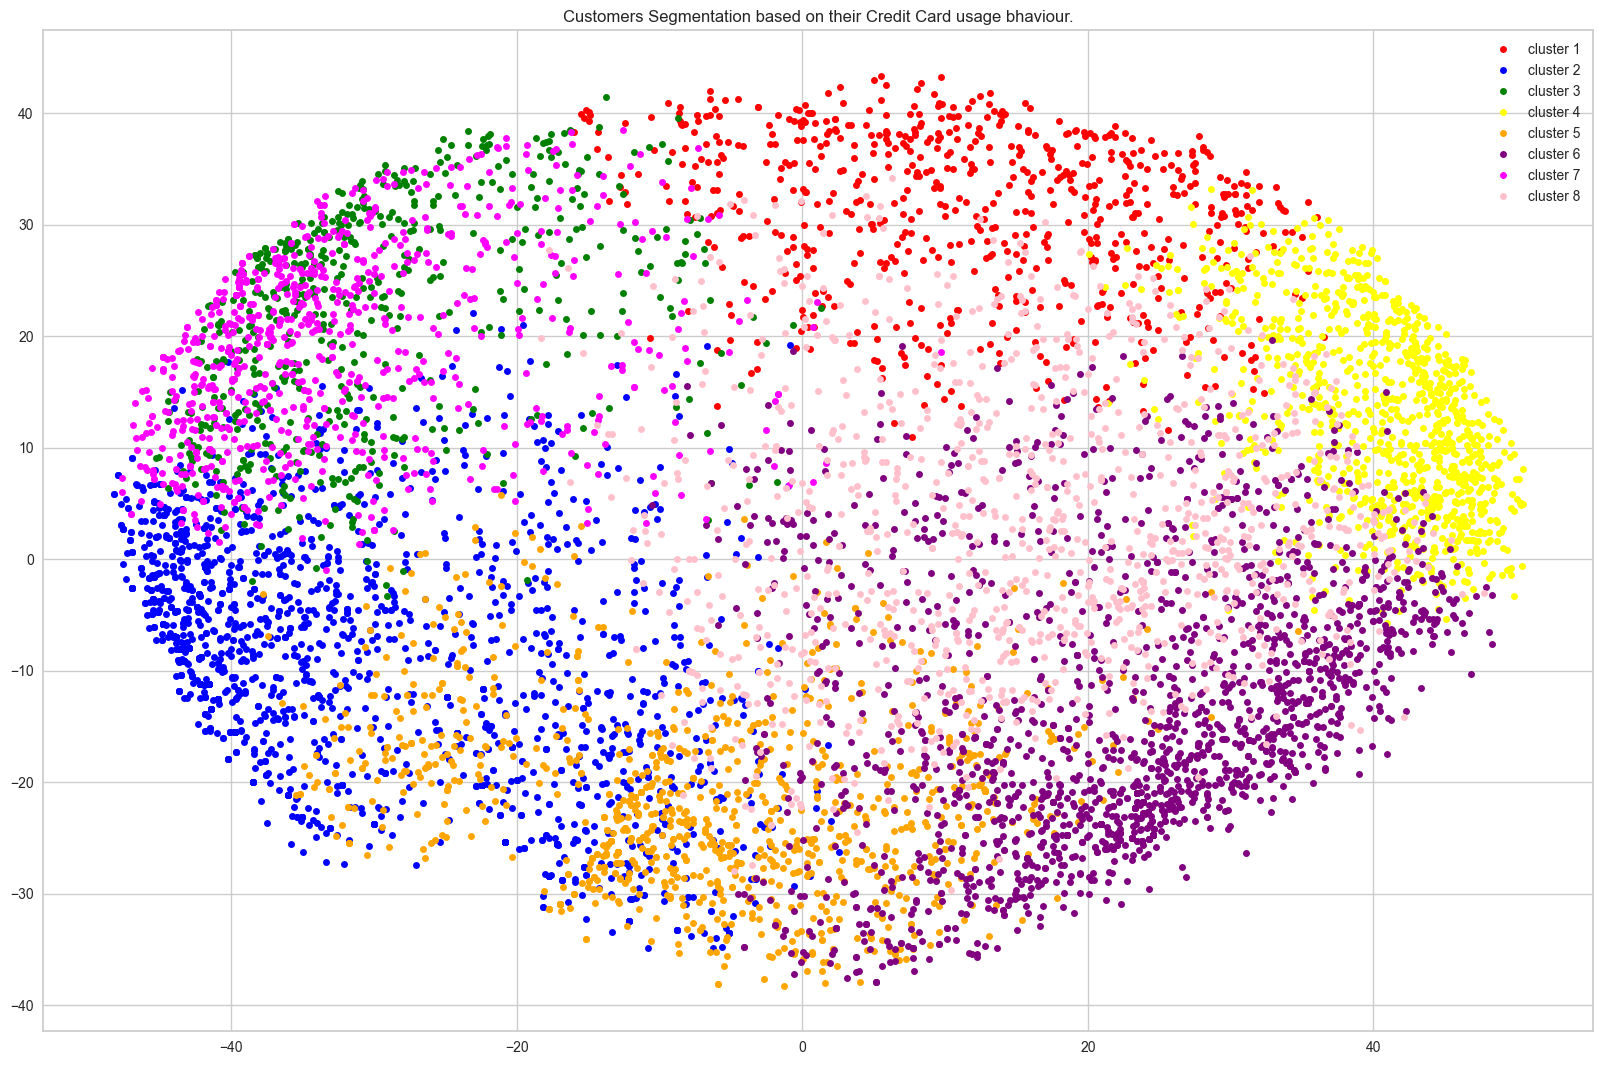

In [354]:
x, y = X_PCA[:, 0], X_PCA[:, 1]

colors = {0: 'red',
          1: 'blue',
          2: 'green', 
          3: 'yellow', 
          4: 'orange',  
          5:'purple',
          6:'fuchsia',
          7:'pink'}

names = {i: f'cluster {i+1}' for i in range(k_clust)}
  
df = pd.DataFrame({'x': x, 'y':y, 'label':labels}) 
groups = df.groupby('label')
fig, ax = plt.subplots(figsize=(20, 13)) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=5,
            color=colors[name],label=names[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(axis='x',which='both',bottom='off',top='off',labelbottom='off')
    ax.tick_params(axis= 'y',which='both',left='off',top='off',labelleft='off')
    
ax.legend()
ax.set_title("Customers Segmentation based on their Credit Card usage bhaviour.")
plt.show()

Визуализация получилась гораздо разборчивее!

### Задача 8.5
Что вы можете сказать о визуализации кластеров после преобразования с помощью косинусного расстояния:
* ничего не изменилось
* кластера стали сильнее различимы - это правильный вариант, но не сильно логичный.
* картина кластеров приняла форму эллипса - это правильный вариант. И логичный.
* картина кластеров  приняла форму квадрата

## Выводы
В данном задании мы на практике:
* определили оптимальное количество кластеров
* решили задачу кластеризации
* попробовали описать характерные зависимости для каждого кластера
* попробовали снизить размерность до 2-х мерной с помощью PCA
* преобразовали данные для лучшей визуализации с помощью косинусного расстояния.